In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
import os
from nltk.corpus import stopwords
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error

from transformers import AutoModel, AutoTokenizer
import json
from tensorflow.keras.models import load_model
import re
import pandas as pd
import string
import keras

In [4]:
data = pd.read_csv('../input/spam-email/spam.csv')

In [5]:
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
idx = [i for i in range(5572)]
data['id'] = idx

In [7]:
data

,Category,Message,id
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,2
3,ham,U dun say so early hor... U c already then say...,3
4,ham,"Nah I don't think he goes to usf, he lives aro...",4
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,5567
5568,ham,Will ü b going to esplanade fr home?,5568
5569,ham,"Pity, * was in mood for that. So...any other s...",5569
5570,ham,The guy did some bitching but I acted like i'd...,5570


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

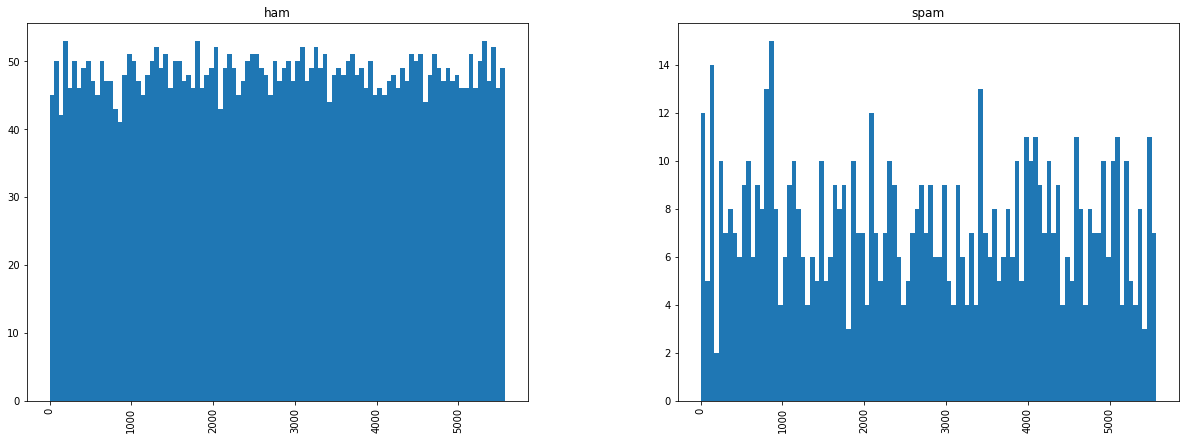

In [8]:
data.hist(column='id', by='Category', bins=100, figsize=(20,7))

In [9]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdcp79g6g
  JVM stdout: /tmp/tmpdcp79g6g/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdcp79g6g/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_unknownUser_ndn0bn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.250 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [10]:
from h2o.automl import H2OAutoML

In [11]:
from h2o.estimators.word2vec import H2OWord2vecEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [12]:
data = h2o.import_file('../input/spam-email/spam.csv',col_names = ["category", "Email"],col_types = ["enum", "string"], header = 1)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [13]:
data.head()

category,Email
Category,Message
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
ham,Ok lar... Joking wif u oni...
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham,U dun say so early hor... U c already then say...
ham,"Nah I don't think he goes to usf, he lives around here though"
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
ham,Even my brother is not like to speak with me. They treat me like aids patent.
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.


In [14]:
data['category'] = data['category'].asfactor()

In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
def tokenize(sentences, stop_word = stop_words):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(stop_words)),:]
    return tokenized_words

In [17]:
def predict(job_title,w2v, gbm):
    words = tokenize(h2o.H2OFrame(job_title).ascharacter())
    job_title_vec = w2v.transform(words, aggregate_method="AVERAGE")
    print(gbm.predict(test_data=job_title_vec))

In [18]:
words = tokenize(data["Email"])

In [19]:
print("Build word2vec model")
w2v_model = H2OWord2vecEstimator(sent_sample_rate = 0.0, epochs = 10)
w2v_model.train(training_frame=words)

Build word2vec model
word2vec Model Build progress: |█████████████████████████████████████████████████| (done) 100%
Model Details
H2OWord2vecEstimator :  Word2Vec
Model Key:  Word2Vec_model_python_1637295064873_1

No model summary for this model


In [20]:
print("Calculate a vector for each job title")
vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")

Calculate a vector for each job title


In [21]:
print("Prepare training&validation data")
categ = ~ vecs["C1"].isna()
data = data[categ,:].cbind(vecs[categ,:])

Prepare training&validation data


In [22]:
data_split = data.split_frame(ratios=[0.8])

In [23]:
aml = H2OAutoML(max_models = 10, max_runtime_secs=1000, seed = 1)

aml.train(x = vecs.names,
                y="category", 
                training_frame = data_split[0])

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_1_20211119_41145


Model Summary: 


,,number_of_trees
0,,52.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.0003279862450212675
RMSE: 0.018110390526470364
LogLoss: 0.004356579164263424
Mean Per-Class Error: 0.000546448087431694
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Category,ham,spam,Error,Rate
0,0.0,0.0,0.0,NaN,0 / 0
1,0.0,3788.0,0.0,0.000000,"0 / 3,788"
2,0.0,1.0,609.0,0.001639,1 / 610
3,0.0,3789.0,609.0,0.000227,"1 / 4,398"



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.999773
1,2,1.000000
2,3,1.000000



ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.015167932632350658
RMSE: 0.12315816104647982
LogLoss: 0.07154775065584584
Mean Per-Class Error: 0.027318076641219612
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Category,ham,spam,Error,Rate
0,0.0,0.0,0.0,NaN,0 / 0
1,0.0,3757.0,31.0,0.008184,"31 / 3,788"
2,0.0,45.0,565.0,0.073770,45 / 610
3,0.0,3802.0,596.0,0.017281,"76 / 4,398"



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.982719
1,2,1.000000
2,3,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.982719,0.003722,0.986364,0.986364,0.978409,0.979522,0.982935
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.017281,0.003722,0.013636,0.013636,0.021591,0.020478,0.017065
3,err_count,15.200000,3.271085,12.000000,12.000000,19.000000,18.000000,15.000000
4,logloss,0.071553,0.020521,0.067465,0.039190,0.085177,0.073634,0.092299
5,max_per_class_error,0.072826,0.039431,0.041667,0.029126,0.122807,0.101562,0.068966
6,mean_per_class_accuracy,0.973005,0.012511,0.983041,0.986430,0.956889,0.963927,0.974741
7,mean_per_class_error,0.026995,0.012511,0.016959,0.013570,0.043111,0.036073,0.025259
8,mse,0.015168,0.003328,0.014146,0.010240,0.019204,0.016778,0.015474
9,pr_auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-11-19 04:16:31,5.545 sec,0.0,0.666667,1.098612,0.138699,NaN,NaN
1,,2021-11-19 04:16:31,5.623 sec,5.0,0.206752,0.220938,0.014552,NaN,NaN
2,,2021-11-19 04:16:31,5.673 sec,10.0,0.109076,0.077105,0.010914,NaN,NaN
3,,2021-11-19 04:16:31,5.722 sec,15.0,0.083788,0.038002,0.007276,NaN,NaN
4,,2021-11-19 04:16:31,5.771 sec,20.0,0.064283,0.021894,0.005457,NaN,NaN
5,,2021-11-19 04:16:31,5.820 sec,25.0,0.049584,0.014409,0.002956,NaN,NaN
6,,2021-11-19 04:16:32,5.873 sec,30.0,0.038600,0.010274,0.001592,NaN,NaN
7,,2021-11-19 04:16:32,5.926 sec,35.0,0.029676,0.007847,0.000227,NaN,NaN
8,,2021-11-19 04:16:32,5.979 sec,40.0,0.024278,0.006354,0.000227,NaN,NaN
9,,2021-11-19 04:16:32,6.040 sec,45.0,0.021006,0.005330,0.000227,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C65,1657.267212,1.000000,0.307341
1,C86,828.224915,0.499753,0.153595
2,C79,356.392456,0.215048,0.066093
3,C55,245.473816,0.148120,0.045523
4,C47,153.084946,0.092372,0.028390
5,C60,152.384048,0.091949,0.028260
6,C53,101.948357,0.061516,0.018906
7,C30,91.609894,0.055278,0.016989
8,C33,91.276299,0.055076,0.016927
9,C29,76.260124,0.046016,0.014142



See the whole table with table.as_data_frame()


In [24]:
leader = aml.leaderboard

leader.head()

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_3_AutoML_1_20211119_41145,0.0273181,0.0715478,0.123158,0.0151679
StackedEnsemble_AllModels_3_AutoML_1_20211119_41145,0.027619,0.0752068,0.117544,0.0138166
StackedEnsemble_BestOfFamily_6_AutoML_1_20211119_41145,0.028059,0.0670602,0.12411,0.0154032
XGBoost_1_AutoML_1_20211119_41145,0.0284805,0.0730414,0.129836,0.0168573
GBM_1_AutoML_1_20211119_41145,0.028499,0.0939574,0.129165,0.0166837
XGBoost_2_AutoML_1_20211119_41145,0.028675,0.0748913,0.125614,0.0157789
StackedEnsemble_AllModels_5_AutoML_1_20211119_41145,0.0290639,0.0664566,0.122977,0.0151233
StackedEnsemble_BestOfFamily_2_AutoML_1_20211119_41145,0.0291334,0.0690547,0.125809,0.0158278
StackedEnsemble_AllModels_2_AutoML_1_20211119_41145,0.0298048,0.0642521,0.121771,0.0148281
StackedEnsemble_BestOfFamily_3_AutoML_1_20211119_41145,0.0300688,0.0645786,0.122057,0.014898


In [25]:
leader.head(rows=leader.nrows)

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_3_AutoML_1_20211119_41145,0.0273181,0.0715478,0.123158,0.0151679
StackedEnsemble_AllModels_3_AutoML_1_20211119_41145,0.027619,0.0752068,0.117544,0.0138166
StackedEnsemble_BestOfFamily_6_AutoML_1_20211119_41145,0.028059,0.0670602,0.12411,0.0154032
XGBoost_1_AutoML_1_20211119_41145,0.0284805,0.0730414,0.129836,0.0168573
GBM_1_AutoML_1_20211119_41145,0.028499,0.0939574,0.129165,0.0166837
XGBoost_2_AutoML_1_20211119_41145,0.028675,0.0748913,0.125614,0.0157789
StackedEnsemble_AllModels_5_AutoML_1_20211119_41145,0.0290639,0.0664566,0.122977,0.0151233
StackedEnsemble_BestOfFamily_2_AutoML_1_20211119_41145,0.0291334,0.0690547,0.125809,0.0158278
StackedEnsemble_AllModels_2_AutoML_1_20211119_41145,0.0298048,0.0642521,0.121771,0.0148281
StackedEnsemble_BestOfFamily_3_AutoML_1_20211119_41145,0.0300688,0.0645786,0.122057,0.014898


In [26]:
db_test = data_split[1]

In [27]:
predictions = aml.predict(db_test[:-1])

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'C100': substituting in a column of NaN
  warnings.warn(w)


In [28]:
(predictions['predict']==db_test['category']).as_data_frame(use_pandas=True).mean()

predict    0.977961
dtype: float64